# Introduction

### Problem Description

It will be written soon.

### Software Requirements

(tensorflow)

# General Preparations

### Import Statements

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import r2_score

import tensorflow as tf

from tqdm import tqdm

Here `tensorflow` is preferred over more easy-to-read `keras`, because it allows forecasting several steps ahead without passing predictions as ground truth. 

### Data Extraction and Exploratory Analysis

In [2]:
ser = pd.read_csv('series_with_plateaus.csv', sep='\t')['value']
ser.head()

0    337.0
1    337.0
2    341.0
3    341.5
4    344.0
Name: value, dtype: float64

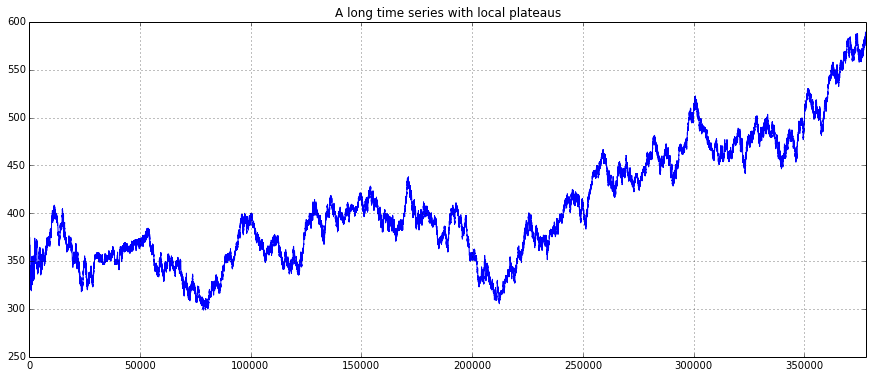

In [3]:
_ = ser.plot(figsize=(15, 6), grid=True,
             title='A long time series with local plateaus')

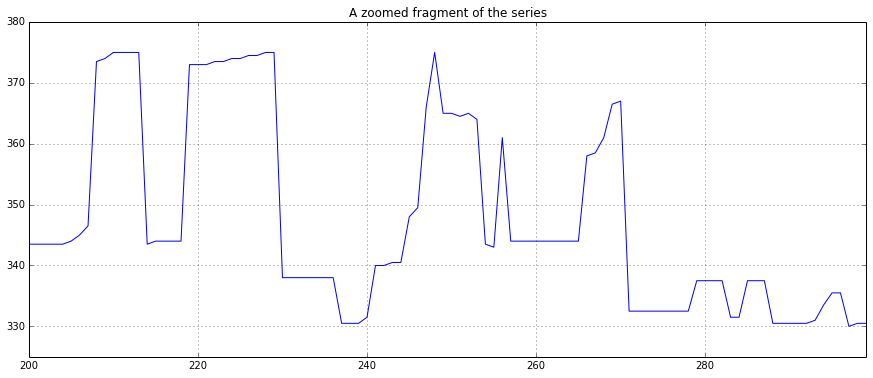

In [4]:
_ = ser[200:300].plot(figsize=(15, 6), grid=True, ylim=[325, 380],
                      title='A zoomed fragment of the series')

### Baseline model

What forecast quality can be achieved by a simple baseline model such as, say, moving average of a specific window size?

Below results of MA(5) model are shown. One can try to use other window sizes — the higher they are, the less slowly predictions made for a long horizon converge to a constant.

In [5]:
window_size = 5

In [6]:
ma_preds = ser.shift().rolling(window=window_size, min_periods=1).mean()
ma_preds.iloc[0] = 0
ma_preds.head()

0      0.000000
1    337.000000
2    337.000000
3    338.333333
4    339.125000
Name: value, dtype: float64

In [7]:
r2_score(ser, ma_preds)

0.99978128694316948

Above score means that almost all variation of the series around its mean can be explained by MA(5). However, this is caused by slow changes in values rather than by outstanding performance of MA(5). Local variations around local means are not explained perfectly. Let us look at some examples.

In [8]:
r2_score(ser[-100:], ma_preds[-100:])

0.72267628392777428

In [9]:
r2_score(ser[-1100:-1000], ma_preds[-1100:-1000])

0.78226717902350607

Another important thing that should be noticed here, is that the above scores relate to multiple one-step-ahead forecasts. If there is a need to create a forecast with long horizon, MA(5) is not a good choice. To see this, split data to a "train" set (actually, MA(5) has no fitting) and a hold-out test set. 

In [10]:
horizon = 100
train_ratio = 0.75
train_test_frontier = int(round(train_ratio * len(ser.index), 0))

100%|██████████| 94367/94367 [00:51<00:00, 1833.63it/s]


-2.0338238915648286

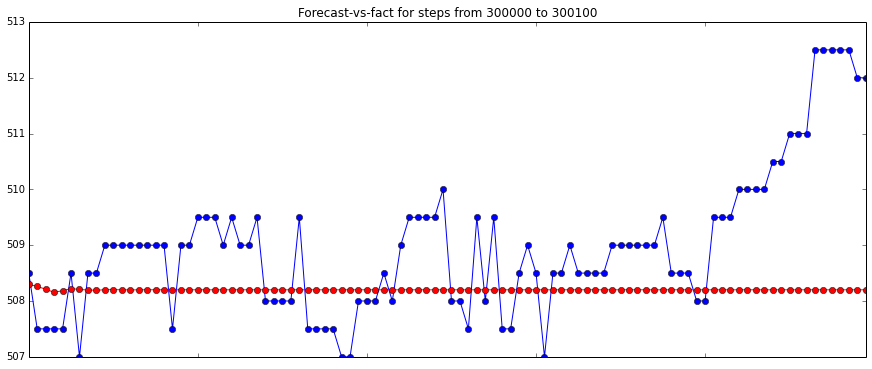

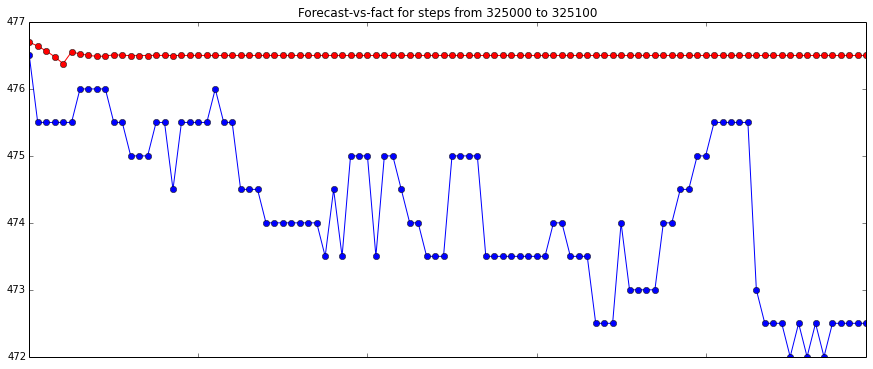

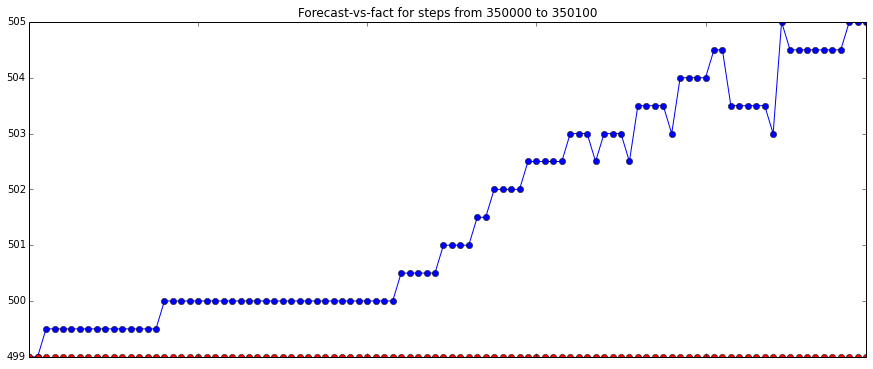

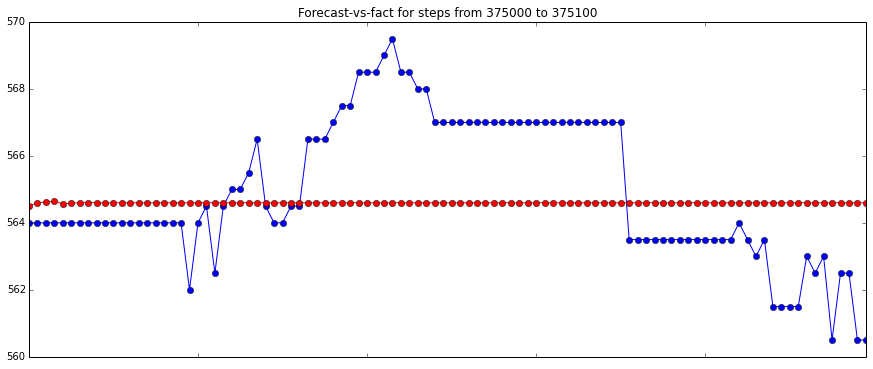

In [11]:
scores = []
for i in tqdm(range(train_test_frontier, len(ser.index) - horizon)):
    y_true = ser.iloc[i:(i + horizon)]
    y_hat = ser.iloc[(i - window_size):i].tolist()
    for j in range(horizon):
        y_hat.append(sum(y_hat[-window_size:]) / window_size)

    y_hat = y_hat[window_size:]
    score = r2_score(y_true, y_hat)
    scores.append(score)
    
    if i % 25000 == 0:
        fig = plt.figure(figsize=(15, 6))
        ax = fig.add_subplot(111)
        ax.set_title('Forecast-vs-fact for steps from {} to {}'.format(i, i + horizon))
        ax.set_xticklabels([])
        
        y_true.plot(ax=ax, marker='o')
        pd.Series(y_hat, index=y_true.index).plot(ax=ax, c='red', marker='o')

sum(scores) / len(scores)

Negative value of $R^2$ score is not a bug. As it can be seen, MA(5) predictions converge rapidly to a constant. If this constant is equal to mean of the corresponding slice from the true series, $R^2$ score is 0, because the model does not explain any variation around the mean. However, any constant that is not equal to the true mean, is worse than the true mean from MSE minimization point of view, and so $R^2$ coefficient of determination is even lower than 0, i.e. it is negative.

# Forecasting with LSTM

### Functions and Classes

In [24]:
def build_rnn(inputs, n_outputs, rnn_width, rnn_depth):
    """
    Defines architecture of an RNN.
    
    @type inputs: tensorflow.Tensor
    @type n_outputs: int
    @type rnn_width: int
    @type rnn_depth: int
    @return: tuple(tensorflow.Tensor)
    """
    basic_cell = tf.contrib.rnn.BasicLSTMCell(rnn_width)
    multi_cell = tf.contrib.rnn.MultiRNNCell([basic_cell for _ in range(rnn_depth)])
    
    batch_size = tf.shape(inputs)[0]
    initial_state = tf.identity(multi_cell.zero_state(batch_size, tf.float32),
                                name='initial_state')
    
    lstm_outputs, final_state = tf.nn.dynamic_rnn(multi_cell, inputs, dtype=tf.float32)
    final_state = tf.identity(final_state, name='final_state')
    
    preds = tf.contrib.layers.fully_connected(lstm_outputs, n_outputs,
                                              activation_fn=None)
    preds = tf.identity(preds, name='predictions')
    return preds, initial_state, final_state

In [25]:
def get_batches_for_lstm(ser, batch_size, horizon, n_lags, n_time_steps=1):
    """
    Converts time series to batches
    represented as data matrices.
    
    @type ser: pandas.Series
    @type batch_size: int
    @type horizon: int
    @type n_lags: int
    @type n_time_steps: int
    @return: list(tuple(numpy.ndarray))
    """
    df = ser.to_frame(name='curr_value')
    for i in range(1, n_lags + 1):
        df['lag_{}'.format(i)] = df['curr_value'].shift(i)
    for i in range(1, horizon + 1):
        df['ahead_{}'.format(i)] = df['curr_value'].shift(-i)
    n_batches = (len(ser) - horizon - n_lags) // batch_size
    df = df.iloc[n_lags:(n_batches*batch_size + n_lags), :]

    x_array = df.iloc[:, :-horizon].values.reshape((n_batches, -1, n_time_steps, n_lags + 1))
    y_array = df.iloc[:, -horizon:].values.reshape((n_batches, -1, n_time_steps, horizon))
    return list(zip(x_array, y_array))

In [29]:
class ExperimentWithLSTM(object):
    """
    """
    # TODO: Fill above docstring.
    
    def __init__(self, horizon, n_lags, rnn_width, rnn_depth):
        """
        @type horizon: int
        @type n_lags: int
        @type rnn_width: int
        @type rnn_depth: int
        """
        self.horizon = horizon
        self.n_lags = n_lags
        self.rnn_width = rnn_width
        self.rnn_depth = rnn_depth
        
        self.sess = None
        
        self.graph = tf.Graph()
        with self.graph.as_default():
            # Define placeholders.
            self.inputs = tf.placeholder(tf.float32,
                                         shape=(None, None, self.n_lags + 1),
                                         name='inputs')
            self.targets = tf.placeholder(tf.float32,
                                          shape=(None, None, self.horizon),
                                          name='targets')
            self.learning_rate = tf.placeholder(tf.float32, name='learning_rate')

            # Build neural network.
            self.preds, self.initial_state, self.final_state = \
                build_rnn(self.inputs, self.horizon, self.rnn_width, self.rnn_depth)

            # Set an optimizational problem.
            self.cost = tf.losses.mean_squared_error(self.targets, self.preds)
            optimizer = tf.train.AdamOptimizer(self.learning_rate)

            # Clip gradients.
            gradients = optimizer.compute_gradients(self.cost)
            capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
            self.train_optim = optimizer.apply_gradients(capped_gradients)
            
    def _train(self, train_ser, batch_size, n_epochs, learn_rate):
        """
        Trains LSTM and informs about training.
        
        @type train_ser: pandas.Series
        @type batch_size: int
        @type n_epochs: int
        @type learn_rate: float
        """
        batches = get_batches_for_lstm(train_ser, batch_size, self.horizon, self.n_lags)

        for epoch_cnt in range(n_epochs):
            state = self.sess.run(self.initial_state, {self.inputs: batches[0][0]})

            for batch_cnt, (x, y) in enumerate(batches):
                feed_dict = {self.inputs: x,
                             self.targets: y,
                             self.initial_state: state,
                             self.learning_rate: learn_rate}
                y_hat, state, train_loss, _ = self.sess.run([self.preds,
                                                             self.final_state,
                                                             self.cost,
                                                             self.train_optim],
                                                            feed_dict)

            if (epoch_cnt * len(batches) + batch_cnt) % 10000 == 0:
                print('Epoch {:>3}   Batch {:>4}/{}   train_loss = {:.3f}'.format(
                    epoch_cnt, batch_cnt, len(batches), train_loss))
                if (epoch_cnt * len(batches) + batch_cnt) % 100000 == 0:
                    print("\nUsed values (from the earliest to the latest):")
                    print((x[0][0]))
                    print("Forecasts are:")
                    print(y_hat[0][0])
                    print("Facts are:")
                    print(y[0][0])
                    print("R^2 is: {}".format(r2_score(y[0][0], y_hat[0][0])))
                    print("If all used values were 500, forecasts would be:")
                    y_hat = self.sess.run(preds,
                                          {self.inputs: [[[500 for _ in range(n_lags + 1)]]],
                                           self.initial_state: state})
                    print(y_hat[0][0])
                    print('\n')

    def _test(self, test_ser):
        """
        Reports performance on hold-out test set
        as coefficient of determination.
        Also visualizes some predictions against
        the corresponding actual values.
        
        @type test_ser: pandas.Series
        @return: float
        """
        scores = []
        batches = get_batches_for_lstm(test_ser, 1, self.horizon, self.n_lags)
        for batch_cnt, (x, y) in tqdm(enumerate(batches)):
            y_hat, state = self.sess.run([self.preds, self.final_state],
                                         {self.inputs: x, self.initial_state: state})
            curr_score = r2_score(y[0][0], y_hat[0][0])
            scores.append(curr_score)

            if batch_cnt % 25000 == 0:
                fig = plt.figure(figsize=(15, 6))
                ax = fig.add_subplot(111)
                ax.set_title('Forecast-vs-fact for steps from {} to {}'.format(i, i + horizon))
                ax.set_xticklabels([])

                pd.Series(y[0][0]).plot(ax=ax, marker='o')
                pd.Series(y_hat[0][0]).plot(ax=ax, c='red', marker='o')
        
        return sum(scores) / len(scores)
        
    def run(self, train_ser, test_ser, batch_size, n_epochs, learn_rate, ckpt_path=None):
        """
        Trains LSTM model with a specified
        hyperparameters on `train_ser` and
        then evaluates its performance on
        `test_ser`.
        If `ckpt_path` is passed, the trained
        model is serialized as check-point
        files.
        
        @type train_ser: pandas.Series
        @type test_ser: pandas.Series
        @type batch_size: int
        @type n_epochs: int
        @type learn_rate: float
        @type ckpt_path: str
        @return: float
        """
        with tf.Session(graph=self.graph) as self.sess:
            self.sess.run(tf.global_variables_initializer())
            
            self._train(train_ser, batch_size, n_epochs, learn_rate)
            if ckpt_path is not None:
                np.save(ckpt_path + '.state', state)
                saver = tf.train.Saver()
                saver.save(self.sess, ckpt_path)
            score = self._test(test_ser)
        return score

### The Experiment Itself

In [27]:
horizon = 100
n_lags = 10

rnn_width = 32
rnn_depth = 4

batch_size = 64
n_epochs = 30
learn_rate = 0.001

In [30]:
experiment_runner = ExperimentWithLSTM(horizon, n_lags, rnn_width, rnn_depth)
score = experiment_runner.run(ser[:train_test_frontier], ser[train_test_frontier:],
                              batch_size, n_epochs, learn_rate,
                              ckpt_path='./trained_models/bare_lstm.ckpt')
score

KeyboardInterrupt: 